# <center> SPM Model with Uniform Particle Diffusion </center>
# <center> Can Behave Closely to DFN at Low C-Rate Cycles </center>


Idea: The main idea of this tutorial is to demonstrate that the results of the Single Particle Model (SPM) with the option of uniform particle diffusion (i.e., averaging lithium concentration along the particle) can closely approximate the behavior of the Doyle-Fuller-Newman model during relatively low C-rate cycling.

Goal: This can be used to save CPU time  for large number of cycles.

1. The model can be used for comparising at different C-rate.
2. It can be used for different SEI model 

In [48]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
param = pybamm.ParameterValues("Chen2020")

In [49]:
param['Initial inner SEI thickness [m]'] = 1e-12
param['Initial outer SEI thickness [m]'] = 1e-12

Remember, 'experiment' is a string-based way to set up how the battery will be cycled. (More information can be found in Tutorial 5.)

In [50]:
# Charging and dischargig rate They could be different, but for simplicity we assume they are the same
ch_c_rates = ["C/50"]
dch_c_rates = ["C/50"]
cycle_no = 2
exps = [pybamm.Experiment(
    [("Charge at {} until 4.2 V".format(ch_c_rate),
      "Rest for 1 hours",
      "Discharge at {} until 2.5 V".format(dch_c_rate),
      )] * cycle_no
) for (ch_c_rate, dch_c_rate) in zip(ch_c_rates, dch_c_rates)]

Comparison single partcicle model (SPM) with Doyle-Fuller-Newman Model  (DFN) with uniform diffison lithoum in option along particles.

In [51]:
sei_models = ["reaction limited", "solvent-diffusion limited",
              "interstitial-diffusion limited", "ec reaction limited"]

# Diffferent SEI models can be used, by setting the index of sei_models
index = 0
options1 = {"SEI": sei_models[index],
            "SEI porosity change": "true"}  # which is default
options2 = {"particle": "uniform profile",
            "SEI": sei_models[index], "SEI porosity change": "true"}

name_models = ["DFN", "SPM"]
models = [
    pybamm.lithium_ion.DFN(options=options1, name=name_models[0]),
    pybamm.lithium_ion.SPM(options=options2, name=name_models[1]),

]

In [52]:
# please note that the size of sims will be equal to the number of models times the number of experiments
sims = [pybamm.Simulation(model, parameter_values=param, experiment=exp)
        for exp in exps for model in models]

Combine all solutions for the different C-rates and models in the list 'sols'

In [53]:
sols = [sim.solve(initial_soc=0) for sim in sims]

In [54]:
# Vaiables to be postprocessed, you can add as many as output variables to the following list
# you can find the list variables to be be output by typing model name dot varaible_name() e.g. here, models[0].variable_names()
out_vars = ['X-averaged negative particle surface concentration [mol.m-3]',
            "Voltage [V]",
            'X-averaged total SEI thickness [m]',
            'X-averaged negative electrode porosity',
            ]

# Label for the output variables y-axis in the plots
yaxis_labels = ["cn",  "Voltage", "SEI_thickness",
                "porosity"]

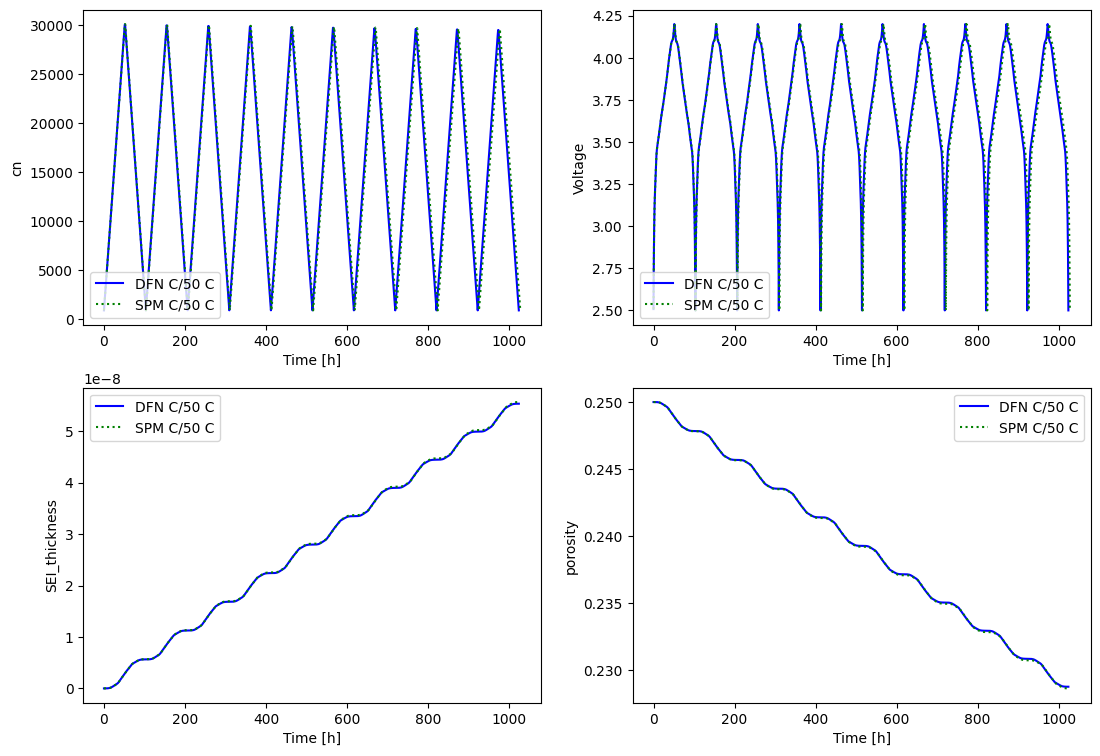

In [55]:

n = int(np.ceil(len(out_vars) / 2))
# generating labels for the plots
Labels = [f"{x} {y} C" for y in dch_c_rates for x in name_models]


fig, axs = plt.subplots(n, 2, figsize=(13, 9))   # sub plot

colors = ['blue', 'green', 'orange', 'purple',
          'brown', 'pink', 'gray', 'olive', 'cyan', 'black']
for i in range(n):  # Loop through the output veriables (out_vars)
    for sol in sols:  # Loop through the models
        line_style = "-" if sols.index(sol) % 2 == 0 else ":"
        axs[i, 0].plot(sol['Time [h]'].entries, sol[out_vars[2*i]].entries,
                       linestyle=line_style, color=colors[int(
                           sols.index(sol) % len(colors))],
                       label=Labels[sols.index(sol)])
#

        axs[i, 1].plot(sol["Time [h]"].entries, sol[out_vars[2*i+1]].entries,
                       linestyle=line_style, color=colors[int(
                           sols.index(sol) % len(colors))],
                       label=Labels[sols.index(sol)])
    axs[i, 0].set_xlabel("Time [h]")
    axs[i, 0].set_ylabel(yaxis_labels[2*i])
    axs[i, 0].legend()
    axs[i, 1].set_xlabel("Time [h]")
    axs[i, 1].set_ylabel(yaxis_labels[2*i+1])
    axs[i, 1].legend()

# axs[i, 1].set_ylabel(yaxis_labels[ sols.index(sol) % len(yaxis_labels)])
# print(sols.index(sol), yaxis_labels[ sols.index(sol) % len(yaxis_labels)])
# axs[i, 1].set_xlabel("Time [h]")

In [56]:
for sol in sols:
    print(sol.solve_time)

2 minutes, 39 seconds
7.019 s


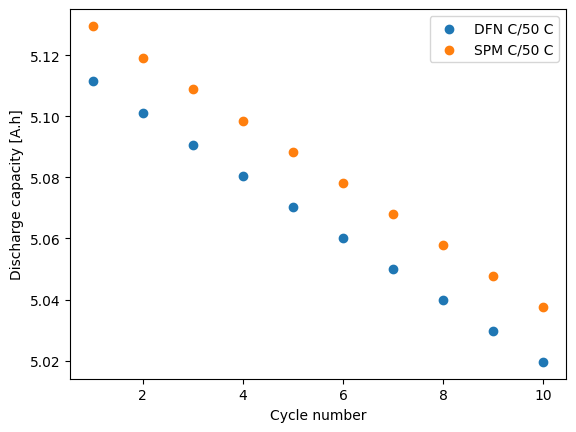

In [57]:
sol_cycles = {}  # Create an empty list to store cycles for all solutions

for sol in sols:
    sol_cycle = []  # Create an empty list for each solution
    for j in range(cycle_no):
        start_capacity = sol.cycles[j].steps[2]["Discharge capacity [A.h]"].entries[0]
        end_capacity = sol.cycles[j].steps[2]["Discharge capacity [A.h]"].entries[-1]
        # Append values to the list for the current solution
        sol_cycle.append(end_capacity - start_capacity)
    plt.scatter(range(1, cycle_no+1, 1), sol_cycle)
    plt.legend(Labels)
    plt.xlabel("Cycle number")
    plt.ylabel("Discharge capacity [A.h]")
    # Append the list for the current solution to the main lis
    sol_cycles[sols.index(sol)] = sol_cycle

Text(0, 0.5, 'Relative error in discharge capacity [%]')

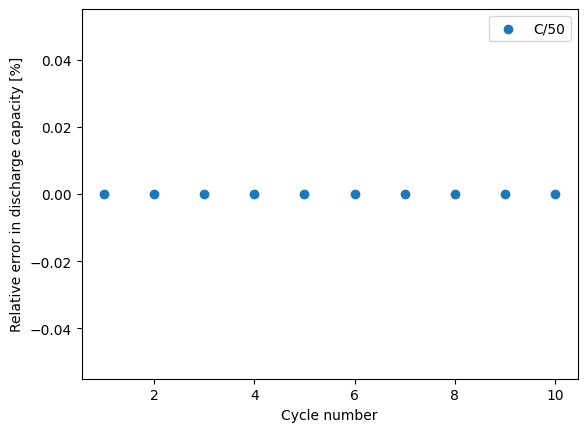

In [58]:
Relative_error_ineach_cycle = {}
for i in range(0, len(sol_cycles) - 1, 2):
    Relative_error_ineach_cycle[i] = [np.round(
        np.abs((a-b)/a)*100) for a, b in zip(sol_cycles[i], sol_cycles[i + 1])]
    plt.scatter(range(1, cycle_no+1, 1), Relative_error_ineach_cycle[i])
plt.legend(ch_c_rates)
plt.xlabel("Cycle number")
plt.ylabel("Relative error in discharge capacity [%]")